# 🕑 Response Time Distribution

# ▶ Run All  and take your ☕ then start from [15]
### 📌 Conclusion at the end

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#df = pd.read_csv('Datasets/NYC_311_Service_Requests_2023.csv')
df = pd.read_csv('Datasets/NYC_311_Service_Requests_2023.csv',low_memory=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3225556 entries, 0 to 3225555
Data columns (total 41 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unique Key                      int64  
 1   Created Date                    object 
 2   Closed Date                     object 
 3   Agency                          object 
 4   Agency Name                     object 
 5   Complaint Type                  object 
 6   Descriptor                      object 
 7   Location Type                   object 
 8   Incident Zip                    object 
 9   Incident Address                object 
 10  Street Name                     object 
 11  Cross Street 1                  object 
 12  Cross Street 2                  object 
 13  Intersection Street 1           object 
 14  Intersection Street 2           object 
 15  Address Type                    object 
 16  City                            object 
 17  Landmark                   

In [9]:
df.columns = df.columns.str.strip().str.replace(r'\s+', '_', regex=True).str.lower()
print (df.columns)

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'facility_type', 'status', 'due_date',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_(state_plane)',
       'y_coordinate_(state_plane)', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location', 'resolution_time_hours',
       'time_diff', 'category'],
      dtype='object')


In [10]:
# Remove spaces at the beginning/end
for col in df.select_dtypes(include=['object', 'string']).columns:
    df[col] = df[col].str.strip()

print("Spaces removed from text columns in the DataFrame.")

Spaces removed from text columns in the DataFrame.


In [11]:
# Convert columns to datetime, treating incorrect values as NaT
df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['closed_date'] = pd.to_datetime(df['closed_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df['resolution_action_updated_date'] = pd.to_datetime(df['resolution_action_updated_date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Calculate the time difference in hours between 'closed_date' and 'created_date'
df['resolution_time_hours'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 3600

# Display the result
print(df[['created_date', 'closed_date', 'resolution_action_updated_date', 'resolution_time_hours']])

               created_date         closed_date  \
0       2023-12-31 23:59:42 2024-01-01 01:51:01   
1       2023-12-31 23:59:39 2024-01-19 14:37:37   
2       2023-12-31 23:59:29 2024-01-01 04:06:24   
3       2023-12-31 23:59:29 2024-01-01 01:51:32   
4       2023-12-31 23:59:23 2024-01-01 00:13:30   
...                     ...                 ...   
3225551 2023-01-01 00:00:46 2023-01-01 01:01:43   
3225552 2023-01-01 00:00:45 2023-01-01 01:24:10   
3225553 2023-01-01 00:00:42 2023-01-01 17:34:15   
3225554 2023-01-01 00:00:09 2023-01-01 00:36:06   
3225555 2023-01-01 00:00:00 2023-01-03 14:56:48   

        resolution_action_updated_date  resolution_time_hours  
0                  2024-01-01 01:51:05               1.855278  
1                  2024-01-19 14:37:41             446.632778  
2                  2024-01-01 04:06:28               4.115278  
3                  2024-01-01 01:51:35               1.867500  
4                  2024-01-01 00:13:33               0.235278  
...

In [12]:
# Calculate the time difference between the two columns
df['time_diff'] = (df['resolution_action_updated_date'] - df['closed_date']).dt.total_seconds()

# Function to categorize time differences and NaN values
def categorize_diff(row):
    # Case where both dates are missing
    if pd.isna(row['closed_date']) and pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated+closed_date'
    
    # Case where only the closed_date is missing
    elif pd.isna(row['closed_date']) and not pd.isna(row['resolution_action_updated_date']):
        return 'nan_closed'
    
    # Case where only the resolution_action_updated_date is missing
    elif pd.isna(row['resolution_action_updated_date']) and not pd.isna(row['closed_date']):
        return 'nan_updated_date'
    
    # If both dates are present, calculate the difference
    else:
        diff_seconds = row['time_diff']
        
        # Categorization based on the time difference
        if 0 <= diff_seconds <= 60:
            return '0-1m'
        elif 60 < diff_seconds <= 600:
            return '1m-10m'
        elif 600 < diff_seconds <= 3600:
            return '10m-1h'
        elif 3600 < diff_seconds <= 86400:
            return '1h-24h'
        elif 86400 < diff_seconds <= 604800:
            return '1d-7d'
        elif diff_seconds > 604800:
            return '7d+'
        else:
            return 'other'  # General case if the difference does not fit any interval

# Apply the function to categorize each row
df['category'] = df.apply(categorize_diff, axis=1)

# Display the final result
print(df[['closed_date', 'resolution_action_updated_date', 'category']])



                closed_date resolution_action_updated_date category
0       2024-01-01 01:51:01            2024-01-01 01:51:05     0-1m
1       2024-01-19 14:37:37            2024-01-19 14:37:41     0-1m
2       2024-01-01 04:06:24            2024-01-01 04:06:28     0-1m
3       2024-01-01 01:51:32            2024-01-01 01:51:35     0-1m
4       2024-01-01 00:13:30            2024-01-01 00:13:33     0-1m
...                     ...                            ...      ...
3225551 2023-01-01 01:01:43            2023-01-01 01:01:49     0-1m
3225552 2023-01-01 01:24:10            2023-01-01 01:24:16     0-1m
3225553 2023-01-01 17:34:15            2023-01-01 17:34:20     0-1m
3225554 2023-01-01 00:36:06            2023-01-01 00:36:10     0-1m
3225555 2023-01-03 14:56:48            2023-01-03 14:56:43    other

[3225556 rows x 3 columns]


Category count:
category
0-1m                       2217952
other                       870234
nan_closed                   61381
nan_updated+closed_date      27374
1h-24h                       26533
7d+                           9637
1d-7d                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
Name: count, dtype: int64


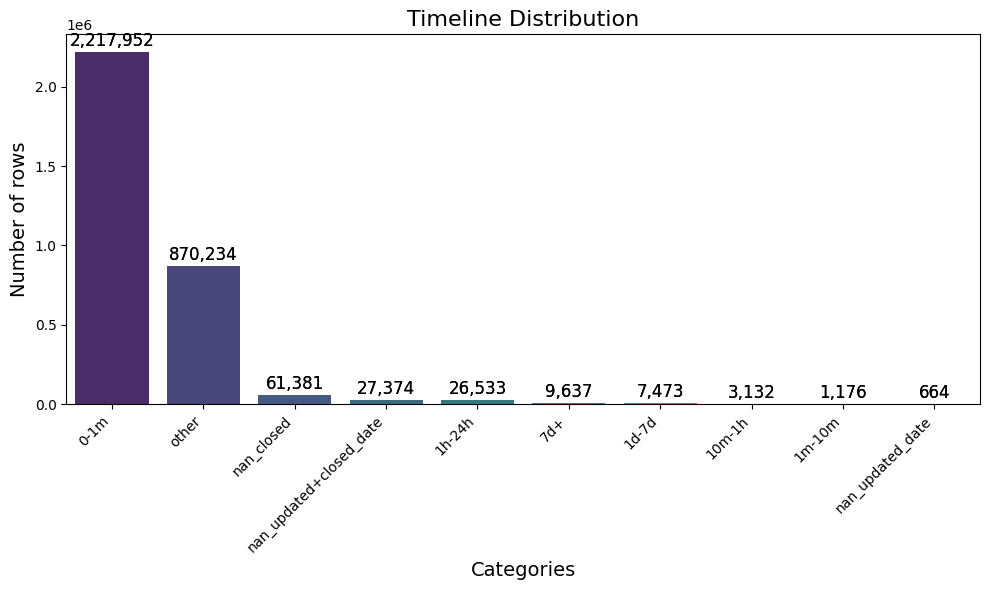

In [13]:
# Calculate the count of different categories
category_counts = df['category'].value_counts()

# Display the results in table format
print("Category count:")
print(category_counts)

# Create a bar chart to visualize the distribution of categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)

# Add labels and a title
plt.title("Timeline Distribution", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Number of rows", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to ensure everything is visible

# Add numerical values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

plt.tight_layout()  # Adjust layout to ensure everything is visible

# Show the chart
plt.show()


In [14]:
# Updated function to categorize time differences, including negative delays
def categorize_diff(row):
    if pd.isna(row['closed_date']) and pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated+closed_date'
    elif pd.isna(row['closed_date']):
        return 'nan_closed'
    elif pd.isna(row['resolution_action_updated_date']):
        return 'nan_updated_date'
    else:
        # Calculate the time difference in seconds
        diff_seconds = (row['resolution_action_updated_date'] - row['closed_date']).total_seconds()

        # Cases for positive delays
        if 0 <= diff_seconds <= 60:
            return '0-1m'
        elif 60 < diff_seconds <= 600:
            return '1m-10m'
        elif 600 < diff_seconds <= 3600:
            return '10m-1h'
        elif 3600 < diff_seconds <= 86400:
            return '1h-24h'
        elif 86400 < diff_seconds <= 604800:
            return '1d-7d'
        elif diff_seconds > 604800:
            return '7d+'
        
        # Cases for negative delays
        elif -10 <= diff_seconds < 0:
            return '-0-1m'
        elif -3600 <= diff_seconds < -10:
            return '-10s-1h'
        elif -86400 <= diff_seconds < -3600:
            return '-1h-24h'
        elif -604800 <= diff_seconds < -86400:
            return '-1d-7d'
        else:
            return '-7d-other'  # If the difference is less than -7 days

# Apply the function to categorize
df['category'] = df.apply(categorize_diff, axis=1)

# Display the results in table format
print("Category count:")
print(df['category'].value_counts())


Category count:
category
0-1m                       2217952
-1h-24h                     751738
-1d-7d                       61692
nan_closed                   61381
-7d-other                    28796
nan_updated+closed_date      27374
1h-24h                       26533
-10s-1h                      15563
-0-1m                        12445
7d+                           9637
1d-7d                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
Name: count, dtype: int64


### ⬇️ Diff entre closed_date et resolution_action_updated_date

Category count:
category
0-1m                       2217952
-1h-24h                     751738
-1d-7d                       61692
nan_closed                   61381
-7d-other                    28796
nan_updated+closed_date      27374
1h-24h                       26533
-10s-1h                      15563
-0-1m                        12445
7d+                           9637
1d-7d                         7473
10m-1h                        3132
1m-10m                        1176
nan_updated_date               664
other                            0
Name: count, dtype: int64


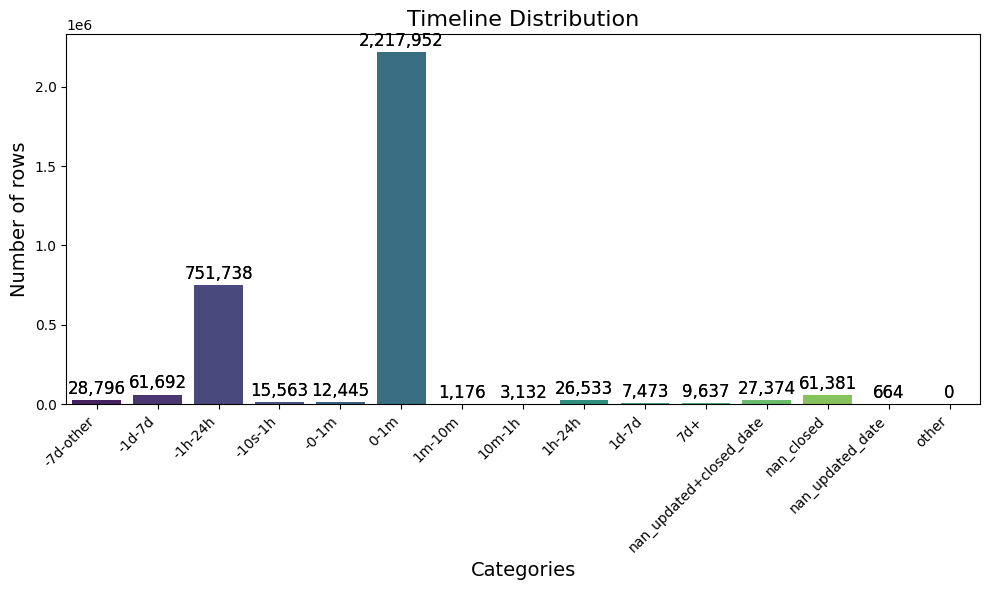

In [16]:
# Define the order of categories chronologically: first negatives, then positives, then NaN and others
category_order = [
    '-7d-other', '-1d-7d', '-1h-24h', '-10s-1h', '-0-1m',  # Negative categories
    '0-1m', '1m-10m', '10m-1h', '1h-24h', '1d-7d', '7d+',   # Positive categories
    'nan_updated+closed_date', 'nan_closed', 'nan_updated_date', 'other'  # NaN and other cases
]

# Apply pd.Categorical to organize categories in the specified order
df['category'] = pd.Categorical(df['category'], categories=category_order, ordered=True)

# Calculate the count of different categories
category_counts = df['category'].value_counts()

# Display the results in table format
print("Category count:")
print(category_counts)

# Create a bar chart to visualize the distribution of categories
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)

# Add labels and a title
plt.title("Timeline Distribution", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Number of rows", fontsize=14)
plt.xticks(rotation=45, ha="right")

# Add numerical values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

plt.tight_layout()  # Adjust layout to ensure everything is visible

# Show the chart
plt.show()

In [17]:
# Find the maximum positive value and the corresponding row
#max_positive = df['time_diff'].max()
#max_positive_row = df[df['time_diff'] == max_positive]

# Find the second smallest negative value and the corresponding row
#second_min_negative = df['time_diff'].nsmallest(2).iloc[-1] if len(df[df['time_diff'] < 0]) >= 2 else None
#second_min_negative_row = df[df['time_diff'] == second_min_negative]

# Display the full results for the corresponding rows
#print(f"Maximum positive value: {max_positive} seconds")
#print("Row corresponding to the maximum positive value:")
#print(max_positive_row.to_string(index=False))  # Displays the full row without the index

#print(f"\nSecond smallest negative value: {second_min_negative} seconds")
#print("Row corresponding to the second smallest negative value:")
#print(second_min_negative_row.to_string(index=False))  # Displays the full row without the index

In [18]:
# Find the longest positive delay
max_time = df["resolution_time_hours"].max()

# Find the most negative delay
min_time = df["resolution_time_hours"].min()

# Function to convert hours into days, hours, minutes, seconds
def convert_hours_to_dhms(hours):
    total_seconds = int(hours * 3600)
    days = total_seconds // 86400
    hours = (total_seconds % 86400) // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{days}d {hours}h {minutes}m {seconds}s"

# Conversion
longest_delay = convert_hours_to_dhms(max_time)
most_negative_delay = convert_hours_to_dhms(min_time)

# Display results
print(f"Longest positive delay (+): {longest_delay}")
print(f"Most negative delay (-): {most_negative_delay}")

Longest positive delay (+): 706d 0h 1m 34s
Most negative delay (-): -378d 0h 0m 0s



⏱️ "resolution_time_hours" Délai positif : 706j 0h 1m 34s (1 017 841,57 minutes)  et Délai négatif : -378j 0h 0m 0s (-544 320 minutes)

In [19]:
print(f"Total NaN in 'resolution_action_updated_date': {df['resolution_action_updated_date'].isna().sum()}")
print(f"Total NaN in 'closed_date': {df['closed_date'].isna().sum()}")

Total NaN in 'resolution_action_updated_date': 28038
Total NaN in 'closed_date': 88755


In [20]:
print(f"Total in 'nan_updated_date': {df[df['category'] == 'nan_updated_date'].shape[0]}")
print(f"Total in 'nan_updated+closed_date': {df[df['category'] == 'nan_updated+closed_date'].shape[0]}")

Total in 'nan_updated_date': 664
Total in 'nan_updated+closed_date': 27374


In [21]:
# Count the number of null (NaN) values in each column
null_counts = df.isnull().sum()

# Display the result
print(null_counts)

unique_key                              0
created_date                            0
closed_date                         88755
agency                                  0
agency_name                             0
complaint_type                          0
descriptor                          97868
location_type                      384752
incident_zip                        38561
incident_address                   123642
street_name                        123723
cross_street_1                     917651
cross_street_2                     916754
intersection_street_1             1050482
intersection_street_2             1048666
address_type                        16275
city                               163916
landmark                          1283630
facility_type                     3208928
status                                  0
due_date                          3213081
resolution_description              67837
resolution_action_updated_date      28038
community_board                   

# Start is here 👇

In [22]:
# Filter rows where time_diff is negative
df_negtimediff = df[df['time_diff'] < 0]

# Display the number of problematic cases
print(f"Number of rows with negative time_diff: {len(df_negtimediff)}")

Number of rows with negative time_diff: 870234


In [23]:
# Filter rows where resolution_time_hours is negative
df_negatives = df[df['resolution_time_hours'] < 0]

# Display the number of problematic cases
print(f"Number of rows with negative resolution_time_hours: {len(df_negatives)}")

Number of rows with negative resolution_time_hours: 4307


In [24]:
# Calculate the time difference in hours between 'resolution_action_updated_date' and 'created_date'
df['diff_updcrea_hours'] = (df['resolution_action_updated_date'] - df['created_date']).dt.total_seconds() / 3600

# Filter negative values
df_negupdcrea = df[df['diff_updcrea_hours'] < 0]

# Display the number of negative values
print(f"Number of rows with a negative difference: {len(df_negupdcrea)}")

Number of rows with a negative difference: 73628


# Missing values in `closed_date`

In [25]:
# 1. Filter rows where 'closed_date' is NaN
missing_closed_date = df[df['closed_date'].isna()]

# 2. Count occurrences of different 'status' values among missing rows
status_counts = missing_closed_date['status'].value_counts()

# 3. Calculate percentages
status_percentages = (status_counts / len(missing_closed_date)) * 100

# 4. Display the results
print("Percentage of rows with missing 'closed_date' by status:")
print(status_percentages)

Percentage of rows with missing 'closed_date' by status:
status
In Progress    71.083319
Closed         22.818996
Open            2.791955
Assigned        1.345276
Pending         1.151484
Started         0.753760
Unspecified     0.055208
Name: count, dtype: float64


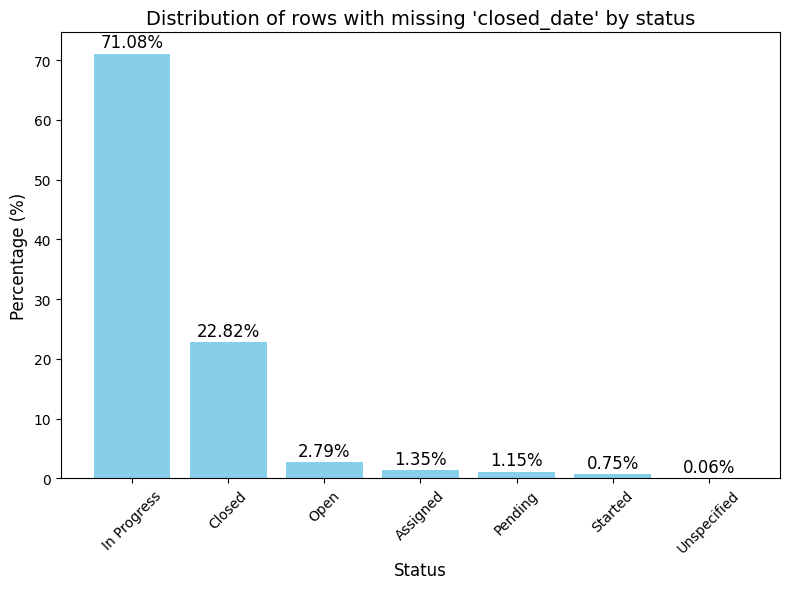

In [28]:
# 4. Create a simple bar chart
plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get the axis object

bars = ax.bar(status_percentages.index, status_percentages.values, color='skyblue')

# Add a title and labels
plt.title("Distribution of rows with missing 'closed_date' by status", fontsize=14)
plt.xlabel("Status", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=10)

# Add numerical values on the bars
for p in bars:
    ax.annotate(f'{p.get_height():,.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Display the chart
plt.tight_layout()
plt.show()

# 🎶 Conclusion:
By comparing the three columns **created_date**, **resolution_action_updated_date**, and **closed_date**, here are the obtained results:

Between **closed_date** and **created_date**, we have:
➖ 4,307 negative dates.  
❕ 88,755 missing dates.  

Between **resolution_action_updated_date** and **closed_date**, we observe:
➖ 870,234 negative dates.  
❕ 28,038 missing dates.  

Finally, when comparing **resolution_action_updated_date** with **created_date**, we note:
➖ 73,628 negative dates.  

For the **88,755 missing closed_date values**, **94%** fall under the status "In progress" or "Closed."  
In the new dataset downloaded on **January 12, 2025**, there are **85,475 missing rows** instead of **88,755** (over the past four weeks).  
This indicates that the column is gradually being populated with **closed dates**.  
More than **3,000 additional dates** have been filled in.

### ⬇️ Difference between `closed_date` and `resolution_action_updated_date`

In [30]:
# Calculate the time difference in minutes between 'closed_date' and 'created_date'
df['diff_clcrea_minutes'] = (df['closed_date'] - df['created_date']).dt.total_seconds() / 60  # Convert to minutes

# Identify rows where 'closed_date' is missing
null_closed_date = df[df['closed_date'].isnull()]

# Create a new category column with a default value
df['category_clcrea'] = 'other'  # Default value

# Display the number of rows where 'closed_date' is missing
print(f"\nNumber of rows with missing 'closed_date': {len(null_closed_date)}")

# **Detailed categorization of negative values**
df.loc[df['diff_clcrea_minutes'].isnull(), 'category_clcrea'] = 'null_closed_date'  # Case where the value is NaN
df.loc[df['diff_clcrea_minutes'] < -7 * 24 * 60, 'category_clcrea'] = '-7d-other'  # Less than -7 days
df.loc[(df['diff_clcrea_minutes'] >= -7 * 24 * 60) & (df['diff_clcrea_minutes'] < -1 * 24 * 60), 'category_clcrea'] = '-1d-7d'  # Between -7 days and -1 day
df.loc[(df['diff_clcrea_minutes'] >= -1 * 24 * 60) & (df['diff_clcrea_minutes'] < -60), 'category_clcrea'] = '-1h-24h'  # Between -1 day and -1 hour
df.loc[(df['diff_clcrea_minutes'] >= -60) & (df['diff_clcrea_minutes'] < -10), 'category_clcrea'] = '-10m-1h'  # Between -1 hour and -10 minutes
df.loc[(df['diff_clcrea_minutes'] >= -10) & (df['diff_clcrea_minutes'] < 0), 'category_clcrea'] = '-0-10m'  # Between -10 minutes and now

# **Categorization of positive values for 0-1m, 1m-10m, 10m-1h**
df.loc[(df['diff_clcrea_minutes'] >= 0) & (df['diff_clcrea_minutes'] < 1), 'category_clcrea'] = '0-1m'
df.loc[(df['diff_clcrea_minutes'] >= 1) & (df['diff_clcrea_minutes'] < 10), 'category_clcrea'] = '1m-10m'
df.loc[(df['diff_clcrea_minutes'] >= 10) & (df['diff_clcrea_minutes'] < 60), 'category_clcrea'] = '10m-1h'

# **Categorization of other values**
df.loc[(df['diff_clcrea_minutes'] >= 60) & (df['diff_clcrea_minutes'] < 1440), 'category_clcrea'] = '1h-24h'
df.loc[(df['diff_clcrea_minutes'] >= 1440) & (df['diff_clcrea_minutes'] < 2880), 'category_clcrea'] = '24h-48h'
df.loc[(df['diff_clcrea_minutes'] >= 2880) & (df['diff_clcrea_minutes'] < 10080), 'category_clcrea'] = '2d-7d'
df.loc[df['diff_clcrea_minutes'] >= 10080, 'category_clcrea'] = '7d+'

# Define the order of categories
category_order = [
    '-7d-other', '-1d-7d', '-1h-24h', '-10m-1h', '-0-10m',  # Negative categories
    '0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2d-7d', '7d+',  # Positive categories
    'null_closed_date', 'other'  # Cases where closed_date is missing
]

# Apply pd.Categorical to organize categories in the specified order
df['category_clcrea'] = pd.Categorical(df['category_clcrea'], categories=category_order, ordered=True)

# Calculate the count of different categories
category_counts = df['category_clcrea'].value_counts()

# Display the results in table format
print("\nCategory counts:")
print(category_counts)

# Display statistics on 'diff_clcrea_minutes'
print("\nStatistics on resolution time:")
print(df['diff_clcrea_minutes'].describe())


Number of rows with missing 'closed_date': 88755

Category counts:
category_clcrea
1h-24h              931729
10m-1h              730504
7d+                 617345
2d-7d               421688
24h-48h             236050
1m-10m              125042
null_closed_date     88755
0-1m                 70136
-1d-7d                3436
-7d-other              383
-1h-24h                333
-10m-1h                128
-0-10m                  27
other                    0
Name: count, dtype: int64

Statistics on resolution time:
count    3.136801e+06
mean     2.037096e+04
std      7.832873e+04
min     -5.443200e+05
25%      4.493333e+01
50%      4.359667e+02
75%      5.757000e+03
max      1.016642e+06
Name: diff_clcrea_minutes, dtype: float64


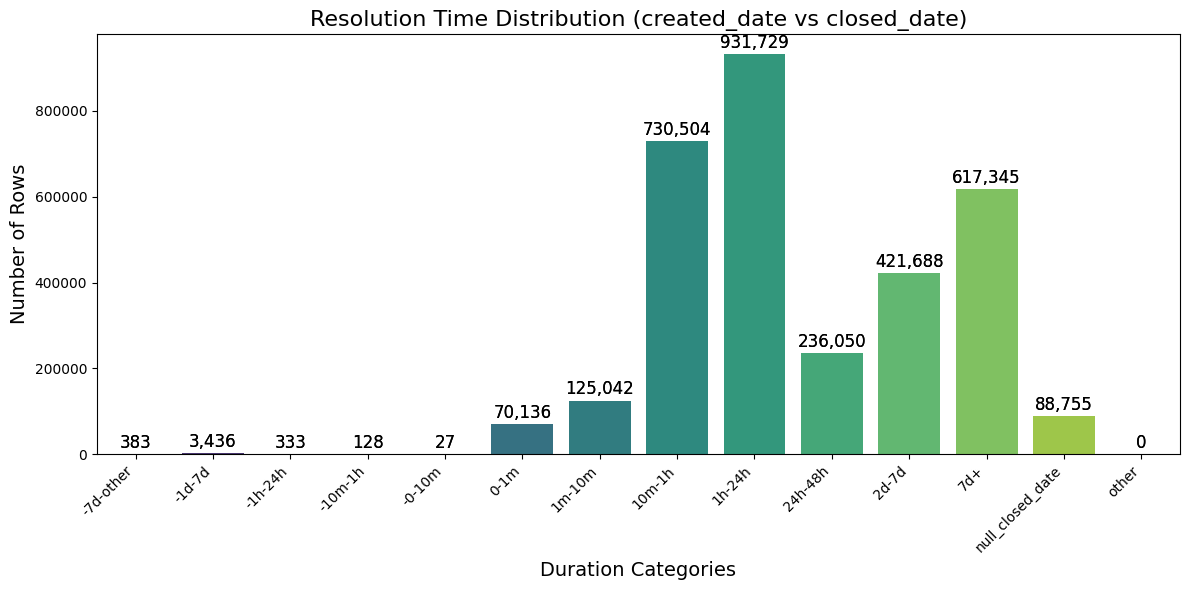

In [31]:
# Check if data is available for the chart
if category_counts.empty:
    print("No data available for displaying the chart.")
else:
    # **Display the chart with two sns.barplot lines**
    plt.figure(figsize=(12, 6))
    
    sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index, legend=False)
    ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis", hue=category_counts.index)

    # Add labels and a title
    plt.title("Resolution Time Distribution (created_date vs closed_date)", fontsize=16)
    plt.xlabel("Duration Categories", fontsize=14)
    plt.ylabel("Number of Rows", fontsize=14)
    plt.xticks(rotation=45, ha="right")

    # Add numerical values on the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=12, color='black', 
                    xytext=(0, 8), textcoords='offset points')

    plt.tight_layout()  # Adjust layout to ensure everything is visible
    plt.show()

Complaints resolved in 0-1m

In [32]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '0-1m'
filtered_complaints = df[df['category_clcrea'] == '0-1m']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
928,Rat Sighting,Rodent,The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.,7353
929,Rat Sighting,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,6648
1046,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,4678
891,Pothole,Street Condition,The Department of Transportation determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.,3968
1162,Work Without A Permit - Occupied Multiple Dwelling,Real Time Enforcement,The Department of Buildings investigated this complaint and determined that no further action was necessary.,2294
244,Condition Attracting Rodents,Rodent,The Department of Health and Mental Hygiene found violations on the property you reported. Follow-up inspections will be scheduled.,2240
245,Condition Attracting Rodents,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,1950
473,Fire Hydrant Emergency (FHE),Water System,The Department of Environmental Protection investigated this complaint and shut the running hydrant.,1603
1007,Signs of Rodents,Rodent,The Department of Health and Mental Hygiene inspected the property you reported and did not find any violations at the time of the inspection. The property passed inspection.,1190
545,Hydrant Running Full (WA4),Water System,The Department of Environmental Protection determined that this complaint is a duplicate of a previously filed complaint. The original complaint is being addressed.,1139


Conclusion: The top 20 complaints in the "0s-1m" category include issues related to rodents, unleashed dogs, unsanitary animals, fire hydrants, street lights out, boilers, and more.

In [33]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                          agency_name  count
2             Department of Health and Mental Hygiene  31264
0                             Department of Buildings  13087
7                        Department of Transportation  12354
8                     New York City Police Department   6389
1              Department of Environmental Protection   5841
4  Department of Housing Preservation and Development    891
5                  Department of Parks and Recreation    219
6                            Department of Sanitation     55
9                       Taxi and Limousine Commission     19
3                     Department of Homeless Services     17


Conclusion:
The top 20 agencies handling "0s-1m" complaints include the Department of Health and Mental Hygiene, Department of Buildings, Department of Transportation, New York City Police Department (NYPD) with 6,389 cases, and the Department of Environmental Protection.

'1m-10m'

In [34]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '1m-10m'
filtered_complaints = df[df['category_clcrea'] == '1m-10m']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
544,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,6663
532,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,6481
1015,Use Outside,Drug Activity,The Police Department responded to the complaint and determined that police action was not necessary.,3825
533,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,3705
506,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,3623
55,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and determined that police action was not necessary.,3514
545,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,3458
531,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and determined that police action was not necessary.,3075
57,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,2887
543,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and determined that police action was not necessary.,2474


Conclusion:
The top 20 complaints in the "1m-10m" category include issues related to Loud Music/Party Noise, Drug Activity, and Illegal Parking.

In [35]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  114949
3               Department of Environmental Protection    4242
5                      Department of Homeless Services    2368
7                   Department of Parks and Recreation    1184
11                       Taxi and Limousine Commission    1015
9                         Department of Transportation     621
8                             Department of Sanitation     377
6   Department of Housing Preservation and Development     240
0                              Department of Buildings      40
2                              Department of Education       4
1         Department of Consumer and Worker Protection       1
4              Department of Health and Mental Hygiene       1


Top 20 complaints of type '10m-1h'

In [36]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '10m-1h'
filtered_complaints = df[df['category_clcrea'] == '10m-1h']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
941,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,50016
953,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,36774
942,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,30225
954,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,23066
1086,No Access,Blocked Driveway,The Police Department issued a summons in response to the complaint.,18887
98,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,18759
908,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,18369
97,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,18251
154,Blocked Hydrant,Illegal Parking,The Police Department issued a summons in response to the complaint.,17233
1368,Posted Parking Sign Violation,Illegal Parking,The Police Department responded to the complaint and took action to fix the condition.,15539


Conclusion:
The top 20 complaints in the "10m-1h" category include issues related to Noise, Blocked Driveway, Blocked Hydrant, Abandoned Vehicle, and Illegal Parking.

In [37]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  696921
3               Department of Environmental Protection   12908
9                         Department of Transportation    7557
7                   Department of Parks and Recreation    3884
5                      Department of Homeless Services    3488
8                             Department of Sanitation    2025
6   Department of Housing Preservation and Development    1482
11                       Taxi and Limousine Commission    1188
4              Department of Health and Mental Hygiene     759
0                              Department of Buildings     258
2                              Department of Education      31
1         Department of Consumer and Worker Protection       3


Top 20 complaints in category '1h-24h'

In [39]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '1h-24h'
filtered_complaints = df[df['category_clcrea'] == '1h-24h']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
2489,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,26574
337,Blocked Hydrant,Illegal Parking,The Police Department responded and upon arrival those responsible for the condition were gone.,25204
2735,No Access,Blocked Driveway,The Police Department responded and upon arrival those responsible for the condition were gone.,24923
335,Blocked Hydrant,Illegal Parking,The Police Department issued a summons in response to the complaint.,18588
2733,No Access,Blocked Driveway,The Police Department issued a summons in response to the complaint.,17657
2488,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,17082
3385,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,16054
2501,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,14967
204,Banging/Pounding,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,14191
4878,With License Plate,Abandoned Vehicle,The Police Department responded to the complaint and took action to fix the condition.,13271


In [40]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
10                     New York City Police Department  570794
8                             Department of Sanitation   91040
6   Department of Housing Preservation and Development   81383
3               Department of Environmental Protection   67955
9                         Department of Transportation   60428
7                   Department of Parks and Recreation   13897
5                      Department of Homeless Services   13539
0                              Department of Buildings   12960
4              Department of Health and Mental Hygiene   11590
1         Department of Consumer and Worker Protection    6514
12                       Taxi and Limousine Commission    1329
2                              Department of Education     291
11                 Office of Technology and Innovation       9


Top 20 complaints in category '24h-48h'

In [41]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '24h-48h'
filtered_complaints = df[df['category_clcrea'] == '24h-48h']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
1178,ENTIRE BUILDING,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,19123
1173,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development responded to a complaint of no heat or hot water and was advised by a tenant in the building that heat and hot water had been restored. If the condition still exists, please file a new complaint.",10167
34,APARTMENT ONLY,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,7059
1167,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",6645
1176,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",6346
32,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",5895
2546,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,5745
24,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted an occupant of the apartment and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",4800
3330,Trash,Dirty Condition,The Department of Sanitation investigated this complaint and found no condition at the location.,4199
1256,Ewaste appointment,Electronics Waste Appointment,The Department of Sanitation collected the E-waste.,4023


In [42]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  109624
8                             Department of Sanitation   60806
3               Department of Environmental Protection   21202
9                         Department of Transportation   19583
0                              Department of Buildings    5750
7                   Department of Parks and Recreation    5526
4              Department of Health and Mental Hygiene    3770
1         Department of Consumer and Worker Protection    3729
10                     New York City Police Department    2987
5                      Department of Homeless Services    2062
12                       Taxi and Limousine Commission     916
2                              Department of Education      89
11                 Office of Technology and Innovation       6


Top 20 complaints in '2d-7d'

In [43]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '2d-7d'
filtered_complaints = df[df['category_clcrea'] == '2d-7d']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
1432,ENTIRE BUILDING,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,16800
1427,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development responded to a complaint of no heat or hot water and was advised by a tenant in the building that heat and hot water had been restored. If the condition still exists, please file a new complaint.",11901
1430,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",10517
29,APARTMENT ONLY,HEAT/HOT WATER,"The Department of Housing Preservation and Development was not able to gain access to your apartment or others in the building to inspect for a lack of heat or hot water. The complaint has been closed. If the condition still exists, please file a new complaint.",8230
2306,MOLD,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8229
3953,Trash,Missed Collection,The Department of Sanitation collected the requested items.,7966
2814,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,6217
2815,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd,5938
31,APARTMENT ONLY,HEAT/HOT WATER,The complaint you filed is a duplicate of a condition already reported by another tenant for a building-wide condition. The original complaint is still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection of your unit if the original complainant is not available for verification.,5725
1421,ENTIRE BUILDING,HEAT/HOT WATER,"The Department of Housing Preservation and Development contacted a tenant in the building and verified that the following conditions were corrected. The complaint has been closed. If the condition still exists, please file a new complaint.",5681


In [44]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  208344
8                             Department of Sanitation   95300
9                         Department of Transportation   39948
3               Department of Environmental Protection   34812
0                              Department of Buildings   13566
7                   Department of Parks and Recreation   12340
4              Department of Health and Mental Hygiene    6378
5                      Department of Homeless Services    3841
1         Department of Consumer and Worker Protection    3691
12                       Taxi and Limousine Commission    2977
10                     New York City Police Department     247
2                              Department of Education     210
11                 Office of Technology and Innovation      34


Top 20 complaints in '7d+'

In [45]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '7d+'
filtered_complaints = df[df['category_clcrea'] == '7d+']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
2765,Other,Noise - Helicopter,"The New York City Economic Development Corporation determined that this issue is not within its jurisdiction because the helicopter did not belong to a tour company departing from a NYC heliport.Â Instead, it was most likely a law enforcement or news gathering helicopter not subject to the routing protocols established for tour helicopters. It may also have been a helicopter that departed as a charter or tour from another City but flew over NYC airspace. Helicopter tours originating from outside NYC are not subject to the same City regulations as tours departing from heliports managed by NYCEDC. Any City regulation of these flights is pre-empted by federal law and subject only to the jurisdiction of the Federal Aviation Administration. To file a complaint with the FAA, you can contact the New York Flight Standards District Office at the following web address:Â https://www.faa.gov/about/office_org/field_offices/fsdo/",42807
2904,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,17471
2908,PESTS,UNSANITARY CONDITION,"The Department of Housing Preservation and Development was not able to gain access to inspect the following conditions. The complaint has been closed. If the condition still exists, please file a new complaint.",12193
2905,PESTS,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd,11728
2433,MOLD,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,11006
1832,GARBAGE/RECYCLING STORAGE,UNSANITARY CONDITION,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,9939
4225,WALL,PAINT/PLASTER,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,9551
1127,DOOR,DOOR/WINDOW,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8443
1639,FLOOR,FLOORING/STAIRS,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,8407
1424,Driver Complaint - Non Passenger,For Hire Vehicle Complaint,The Taxi and Limousine Commission (TLC) reviewed your complaint. The driver or owner pled guilty to a violation and paid a fine. TLC has sent you a written confirmation of this outcome.,8164


In [46]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                           agency_name   count
6   Department of Housing Preservation and Development  280999
7                   Department of Parks and Recreation   61434
0                              Department of Buildings   55153
8                             Department of Sanitation   50365
9                         Department of Transportation   47580
10                    Economic Development Corporation   45527
13                       Taxi and Limousine Commission   26088
3               Department of Environmental Protection   21648
4              Department of Health and Mental Hygiene   21352
1         Department of Consumer and Worker Protection    4100
5                      Department of Homeless Services    2088
2                              Department of Education     774
11                     New York City Police Department     128
12                 Office of Technology and Innovation     109


## Negative response times

Top 20 complaints in '-0-10m'

In [47]:
# Set Pandas to display full column width (avoid truncation)
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '-0-10m'
filtered_complaints = df[df['category_clcrea'] == '-0-10m']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
9,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,12
5,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,2
1,Blocked Hydrant,Illegal Parking,The Police Department responded to the complaint and took action to fix the condition.,1
0,Blocked Bike Lane,Illegal Parking,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,1
3,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,1
2,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and determined that police action was not necessary.,1
4,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and a report was prepared.,1
6,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,1
7,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint but officers were unable to gain entry into the premises.,1
8,No Access,Blocked Driveway,The Police Department responded and upon arrival those responsible for the condition were gone.,1


In [48]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                          agency_name  count
1                        Department of Transportation     12
2                     New York City Police Department     11
0  Department of Housing Preservation and Development      4


Top 20 de '-10m-1h'

In [49]:
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '-10m-1h'
filtered_complaints = df[df['category_clcrea'] == '-10m-1h']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
14,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,25
9,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and took action to fix the condition.,19
25,Pothole,Street Condition,The Department of Transportation inspected this complaint and repaired the problem.,13
4,Loud Music/Party,Noise - Commercial,The Police Department responded to the complaint and took action to fix the condition.,11
10,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,6
24,Posted Parking Sign Violation,Illegal Parking,The Police Department responded to the complaint and determined that police action was not necessary.,6
11,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint but officers were unable to gain entry into the premises.,3
7,Loud Music/Party,Noise - Residential,The Police Department responded to the complaint and a report was prepared.,2
19,Loud Talking,Noise - Street/Sidewalk,The Police Department responded to the complaint and took action to fix the condition.,2
15,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complaint and with the information available observed no evidence of the violation at that time.,2


In [50]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                          agency_name  count
2                     New York City Police Department     93
0  Department of Housing Preservation and Development     22
1                        Department of Transportation     13


Top 20 complaints in '-1h-24h'

In [51]:
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '-1h-24h'
filtered_complaints = df[df['category_clcrea'] == '-1h-24h']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
0,Pothole,Street Condition,The Department of Transportation inspected this complaint and did not find the reported problem.,3


In [52]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                                          agency_name  count
1  Department of Housing Preservation and Development    293
0                             Department of Buildings     37
2                        Department of Transportation      3


Top 20 complaints in '-1d-7d'

In [53]:
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '-1d-7d'
filtered_complaints = df[df['category_clcrea'] == '-1d-7d']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
45,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,1903
44,Street Light Out,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",371
26,Lamppost Base Door/Cover Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,246
7,Fixture/Luminaire Door Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,150
13,Fixture/Luminaire Out Of Position,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,146
35,Multiple Street Lights Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,79
9,Fixture/Luminaire Hanging,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,75
38,Street Light Cycling,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,71
36,Photocell (PEC) Missing,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,41
39,Street Light Dayburning,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,40


In [54]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                              agency_name  count
1            Department of Transportation   3431
0  Department of Environmental Protection      5


Top 20 complaints in '-7d-other'

In [55]:
pd.set_option('display.max_colwidth', None)

# Filter data for complaints of type '-7d-other'
filtered_complaints = df[df['category_clcrea'] == '-7d-other']

# Group by 'descriptor', 'complaint_type', 'resolution_description' and count occurrences
top_20_complaints = (
    filtered_complaints.groupby(['descriptor', 'complaint_type', 'resolution_description'])
    .size()
    .reset_index(name='count')
)

# Sort by count in descending order and select the top 20
top_20_complaints = top_20_complaints.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'descriptor', 'complaint_type', 'resolution_description'
table = top_20_complaints[['descriptor', 'complaint_type', 'resolution_description', 'count']]

from IPython.display import display
display(table)

,descriptor,complaint_type,resolution_description,count
31,Street Light Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,176
30,Street Light Out,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",85
26,Multiple Street Lights Out,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,15
28,Street Light Cycling,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,13
19,Lamppost Base Door/Cover Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,11
9,Fixture/Luminaire Out Of Position,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,9
2,Fixture/Luminaire Damaged,Street Light Condition,"Service Request status for this request is available on the Department of Transportation's website. Please click the ""Learn More"" link below.",9
24,Multiple St Lts Dayburning,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,6
4,Fixture/Luminaire Door Open,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,6
12,Foreign Attachment On Lamppost,Street Light Condition,Service Request status for this request is available on the Department of Transportationâs website. Please click the âLearn Moreâ link below.,5


In [56]:
# Group by 'agency_name' and count occurrences
top_20_agencies = filtered_complaints.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order and select the top 20
top_20_agencies = top_20_agencies.sort_values(by='count', ascending=False).head(20)

# Create a clear table with the columns 'agency_name' and 'count'
table_agencies = top_20_agencies[['agency_name', 'count']]

# Display the table of the top 20 agencies
print(table_agencies)

                              agency_name  count
2            Department of Transportation    373
0  Department of Environmental Protection      9
1                Department of Sanitation      1


In [57]:
# Filter complaints for the specified categories
filtered_complaints_selected = df[df['category_clcrea'].isin(['-7d-other', '-1d-7d', '-1h-24h', '-10s-1h', '-0-1m'])]

# Group by 'agency_name' and count occurrences
top_agencies = filtered_complaints_selected.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order
top_agencies = top_agencies.sort_values(by='count', ascending=False)

# Create a table with the columns 'agency_name' and 'count'
table_agencies = top_agencies[['agency_name', 'count']]

# Display the table of agencies
print(table_agencies)

                                          agency_name  count
4                        Department of Transportation   3807
2  Department of Housing Preservation and Development    293
0                             Department of Buildings     37
1              Department of Environmental Protection     14
3                            Department of Sanitation      1


# Conclusion: 📊 Negative response times are primarily driven by:

Department of Transportation → 3,832 cases (88.97%)

Department of Housing Preservation and Development → 319 cases (7.41%)

New York City Police Department → 104 cases (2.41%)

Department of Buildings → 37 cases (0.86%)

Department of Environmental Protection → 14 cases (0.33%)

Department of Sanitation → 1 case (0.02%)

In [58]:
# Filter complaints for the specified categories
filtered_complaints_selected = df[df['category_clcrea'].isin(['0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2d-7d', '7d+', 'null_closed_date'])]

# Group by 'agency_name' and count occurrences
top_agencies = filtered_complaints_selected.groupby(['agency_name']).size().reset_index(name='count')

# Sort by the number of occurrences in descending order
top_agencies = top_agencies.sort_values(by='count', ascending=False)

# Create a table with the columns 'agency_name' and 'count'
table_agencies = top_agencies[['agency_name', 'count']]

# Display the table of agencies
print(table_agencies)

                                           agency_name    count
11                     New York City Police Department  1392416
6   Department of Housing Preservation and Development   686637
8                             Department of Sanitation   302029
9                         Department of Transportation   191116
3               Department of Environmental Protection   170082
7                   Department of Parks and Recreation   127796
0                              Department of Buildings   100915
4              Department of Health and Mental Hygiene    85191
10                    Economic Development Corporation    59127
5                      Department of Homeless Services    47628
13                       Taxi and Limousine Commission    35814
1         Department of Consumer and Worker Protection    20927
2                              Department of Education     1399
12                 Office of Technology and Innovation      172


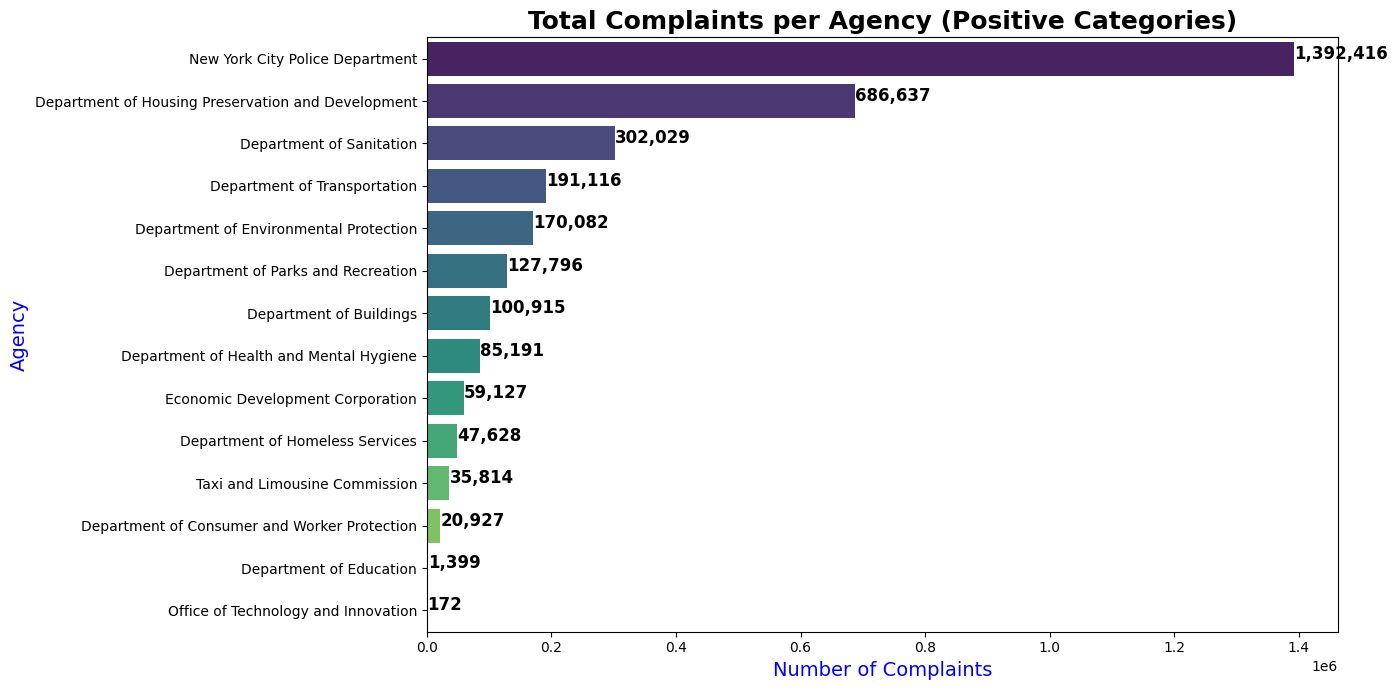

In [59]:
# Filter complaints for the specified categories
filtered_complaints_selected = df[df['category_clcrea'].isin(['0-1m', '1m-10m', '10m-1h', '1h-24h', '24h-48h', '2d-7d', '7d+', 'null_closed_date'])]

# Calculate the total number of complaints per agency in the filtered data
agency_name = filtered_complaints_selected['agency_name'].value_counts()

# Create the figure
plt.figure(figsize=(14, 7))

# Generate the bar chart with proper settings
ax = sns.barplot(
    x=agency_name.values,
    y=agency_name.index,
    hue=agency_name.index,  # Use 'hue' to add colors by agency
    dodge=False,  # Avoid bar displacement
    palette='viridis',
    legend=False  # Disable the legend
)

# Add values above the bars
for index, value in enumerate(agency_name.values):
    plt.text(value + 500, index, f'{value:,}', ha='left', fontsize=12, fontweight='bold')

# Add title and adjust labels
plt.title("Total Complaints per Agency (Positive Categories)", fontsize=18, fontweight='bold')
plt.xlabel("Number of Complaints", fontsize=14, color="blue")
plt.ylabel("Agency", fontsize=14, color="blue")

# Optimize display
plt.tight_layout()

# Display the chart
plt.show()

# Conclusion : 📊 Positive response times are primarily driven by:

New York City Police Department (NYPD) → 1,392,416 cases (43.1%)

Department of Housing Preservation and Development → 686,637 cases (21.3%)

Department of Sanitation → 302,029 cases (9.4%)

Department of Transportation → 191,116 cases (5.9%)

Department of Environmental Protection → 170,082 cases (5.3%)

Department of Parks and Recreation → 127,796 cases (3.95%)

Department of Buildings → 100,915 cases (3.1%)

Department of Health and Mental Hygiene → 85,191 cases (2.6%)

Economic Development Corporation → 59,127 cases (1.8%)

Department of Homeless Services → 47,628 cases (1.5%)

Taxi and Limousine Commission → 35,814 cases (1.1%)

Department of Consumer and Worker Protection → 20,927 cases (0.65%)

Department of Education → 1,399 cases (0.04%)

Office of Technology and Innovation → 172 cases (0.005%)

# 📊 General conclusions 🌏🌟📣

# ✅ 64,84% of complaints are resolved within 48 hours  🕑

The shortest resolution times (0-1 minute and 1-10 minutes) primarily involve complaints that can be automatically classified or quickly assessed, likely requiring minimal human intervention.

The longest resolution times (2 days or more) typically involve complex interventions, such as detailed inspections, investigations, or corrective work, which take longer to address due to their nature and required resources.

1. Short Resolution Times 🔸

🤖 The complaint is automatically classified:</br>
⮞ Duplicate case detected → Some complaints are identified as duplicates and immediately merged with existing requests.

⮞ No violation found → A large number of complaints related to noise disturbances or rodents (rats, mice, and conditions favoring their presence) dominate this category. These are closed without further action after a quick automated assessment.

⮞ Information is immediately available → Some reports simply redirect the complainant to an official website (e.g., checking the status of a streetlight on the Department of Transportation website).

🤠 The police can quickly assess the situation:</br>
⮞ The NYPD resolves many noise complaints and illegal parking issues within minutes, often after a quick on-site check.

💬 No physical intervention is required:</br>
Some issues are resolved by sending a warning message to the responsible party, without an immediate inspection.</br>
✔️ Examples: Off-leash dogs, minor sanitation concerns.

✨ Key agencies involved:</br>
New York City Police Department (NYPD) → Noise complaints, illegal parking, minor disturbances.</br>
Department of Health and Mental Hygiene → Rodents, sanitation conditions.</br>
Department of Environmental Protection → Water issues, reports of leaks, or open hydrants.

⚠️ Ultra-fast resolutions do not necessarily mean that the issue has been genuinely resolved. Instead, they often indicate that an administrative process or filtering rule allowed the complaint to be closed quickly. ⚠️

This could happen due to:</br>
✔️ Automatic classification (e.g., duplicate detection, no violation found).</br>
✔️ Redirecting complaints to self-service resources instead of intervention.</br>
✔️ Minimal police or agency action (e.g., quick assessment but no follow-up).

2. Long Resolution Times 🔸

❗ These cases require investigations, physical inspections, or work interventions. 🧐

🛠️ Complex Repairs and Interventions:</br>
⮞ Urban infrastructure (streetlights, hydrants, parks, waste collection, road conditions, mold, pests, unsanitary conditions) → These issues take time due to resource mobilization and execution of repairs.</br>
⮞ Housing access and inspections add logistical challenges, requiring coordination between agencies, landlords, and tenants.

💡 Recurring Issue: Some cases are closed without violations, forcing residents to resubmit complaints. If a partial resolution occurs, a new complaint may be filed, extending the total resolution time.

📜 Administrative and Legal Processes:</br>
⮞ Abandoned vehicles with plates → Ownership verification and potential towing.</br>
⮞ Cases requiring legal procedures or compliance measures (e.g., illegal construction) → Property owners must be notified and given time to resolve the issue before facing penalties.

✨ Key Agencies Involved:</br>
Department of Buildings (DOB) → Illegal construction, structural inspections.</br>
Department of Housing Preservation and Development (HPD) → Unsanitary housing, landlord-related complaints.</br>
Department of Transportation (DOT) → Road and infrastructure repairs.</br>
Department of Parks and Recreation → Park and public space maintenance.</br>
Department of Environmental Protection → Water issues requiring testing and technical interventions.

📌 Agency efficiency, particularly HPD, is tested by these recurring complaints.</br>
✔️ Better coordination of interventions and stricter follow-ups are needed for improved resolution times.
